In [42]:
import os
from glob import glob
import numpy as np
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer 

from dataset import CardiacDataset
from model import UNet

In [44]:
root = Path("C:/Users/jay Lakshmi/Downloads/Task02_Heart/Task02_Heart/imagesTr")
label = Path("C:/Users/Jay Lakshmi/Downloads/Task02_Heart/Task02_Heart/imagesTr")


In [45]:
def change_img_to_label_path(path):
    parts = list(path.parts)  
    parts[parts.index("imagesTr")] = "labelsTr"  
    return Path(*parts) 

In [46]:
sample_path = list(root.glob("la*"))[0]  
sample_path_label = change_img_to_label_path(sample_path)

In [47]:
sample_path, sample_path_label

(WindowsPath('C:/Users/jay Lakshmi/Downloads/Task02_Heart/Task02_Heart/imagesTr/la_003.nii.gz'),
 WindowsPath('C:/Users/jay Lakshmi/Downloads/Task02_Heart/Task02_Heart/labelsTr/la_003.nii.gz'))

In [48]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

In [49]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

In [50]:
from celluloid import Camera
from IPython.display import HTML

<IPython.core.display.Javascript object>


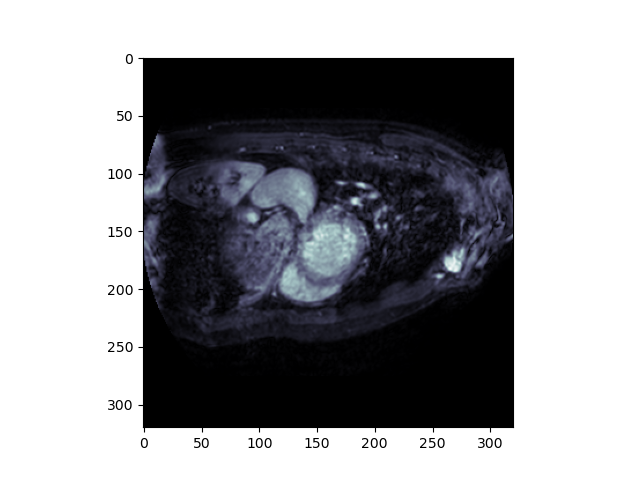

In [51]:
fig = plt.figure()
camera = Camera(fig)  

for i in range(mri.shape[2]):  
    plt.imshow(mri[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    
    camera.snap()  
animation = camera.animate()  


In [52]:
from IPython.display import HTML
HTML(animation.to_html5_video())

In [53]:
def normalize(full_volume):
   
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data


In [54]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

In [55]:
all_files = list(root.glob("la*"))  # Get all subjects
len(all_files)

20

In [56]:
save_root = Path("Preprocessed")

for counter, path_to_mri_data in enumerate(tqdm(all_files)):
    
    path_to_label = change_img_to_label_path(path_to_mri_data)
    
    mri = nib.load(path_to_mri_data)
    assert nib.aff2axcodes(mri.affine) == ("R", "A", "S")    
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)

    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]
    
   
    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)
    
    if counter < 17:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    for i in range(standardized_mri_data.shape[-1]):
        slice = standardized_mri_data[:,:,i]
        mask = label_data[:,:,i]
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)
        
        

  0%|          | 0/20 [00:00<?, ?it/s]

In [57]:
path = Path("Preprocessed/train/1/")

In [58]:
file = "50.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

<IPython.core.display.Javascript object>


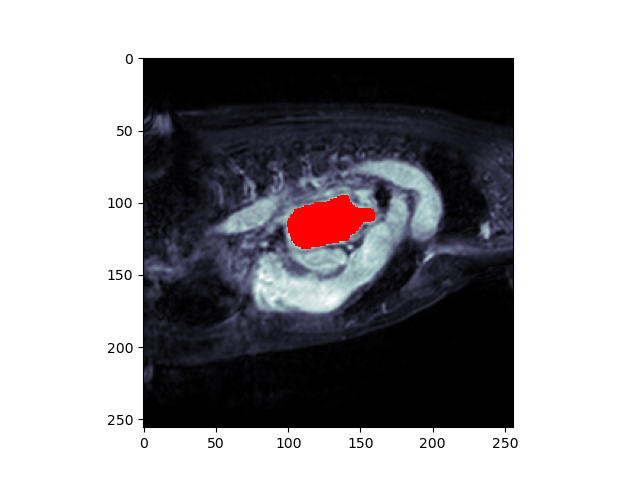

In [59]:
plt.figure()
plt.imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, cmap="autumn")

In [60]:
print(slice.min(), slice.max())

0.0 0.8387631143014908


In [61]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
    
    @staticmethod
    def extract_files(root):
       
        files = []
        for subject in root.glob("*"):   
            slice_path = subject/"data"  
            for slice in slice_path.glob("*.npy"):
                files.append(slice)
        return files
    
    
    @staticmethod
    def change_img_to_label_path(path):
        
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):

        random_seed = torch.randint(0, 1000000, (1,)).item()
        imgaug.seed(random_seed)
        
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug
    
    def __len__(self):
       
        return len(self.all_files)
    
    
    def __getitem__(self, idx):
        
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path).astype(np.float32)  # Convert to float for torc
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        
     

        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)
        

In [62]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

In [63]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), 
               rotate=(-45, 45)),  
    iaa.ElasticTransformation()  
                ])


In [64]:
path = Path("Preprocessed/train/")
dataset = CardiacDataset(path, seq)

<IPython.core.display.Javascript object>


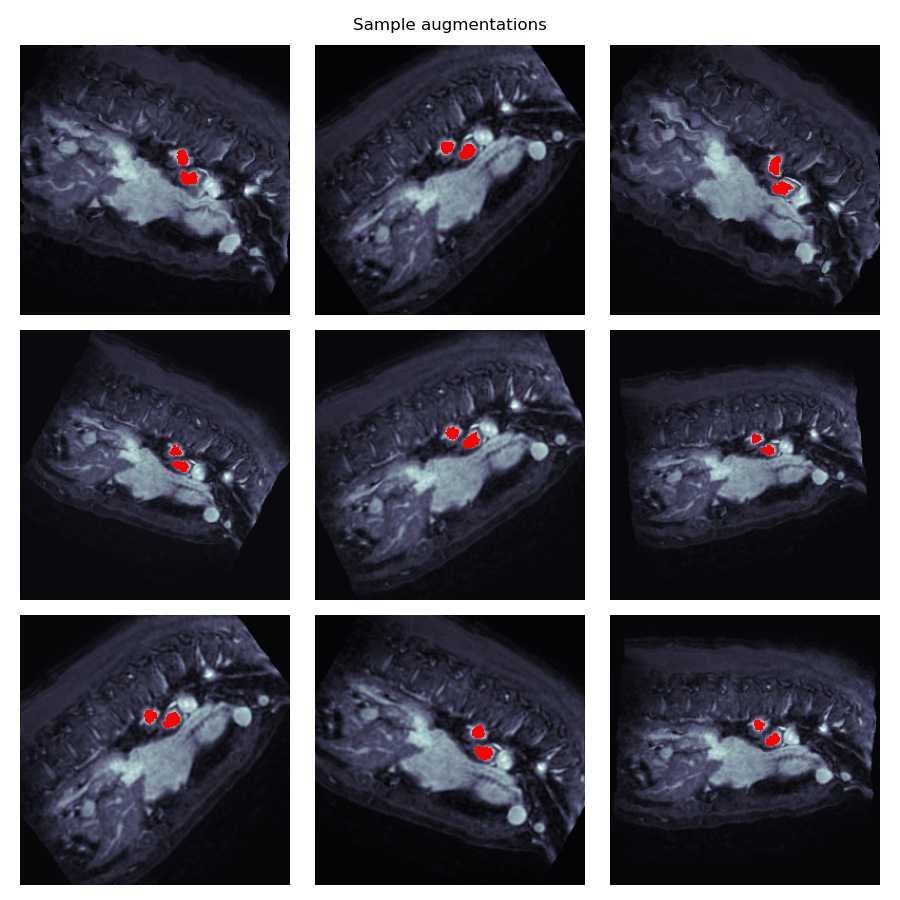

In [65]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice, mask = dataset[3]
        mask_ = np.ma.masked_where(mask==0, mask)
        axis[i][j].imshow(slice[0], cmap="bone")
        axis[i][j].imshow(mask_[0], cmap="autumn")
        axis[i][j].axis("off")

fig.suptitle("Sample augmentations")
plt.tight_layout()


In [66]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())
        
    def forward(self, X):
        return self.step(X)
    

In [67]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)
        
        self.layer5 = DoubleConv(512+256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)
        
        self.maxpool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        
        x4 = self.layer4(x3m)
        
        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)
        
        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)
        
        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        
        ret = self.layer8(x7)
        return ret

In [68]:
model = UNet()

In [69]:
random_input = torch.randn(1, 1, 256, 256)
output = model(random_input)
assert output.shape == torch.Size([1, 1, 256, 256])

C:\Users\Jay Lakshmi\anaconda3\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [71]:
! pip install setuptools==59.5.0

In [72]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
              rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [73]:

train_path = Path("Preprocessed/train/")
val_path = Path("Preprocessed/val")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 1932 train images and 339 val images


In [74]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [75]:
class DiceLoss(torch.nn.Module):
   
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        counter = (pred * mask).sum()        
        denum = pred.sum() + mask.sum() + 1e-8 
        dice =  (2*counter)/denum
        return 1 - dice


In [76]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Dice", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Dice", loss)
        
        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")
            
        return loss
    
    def log_images(self, mri, pred, mask, name):
        
        pred = pred > 0.5
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        
        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)
        
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [77]:
torch.manual_seed(0)
model = AtriumSegmentation()

In [78]:
checkpoint_callback = ModelCheckpoint(monitor='Val Dice', save_top_k=10, mode='min')

In [79]:

trainer =pl.Trainer(gpus=0, logger=TensorBoardLogger(save_dir="./logs"),
                    callbacks=[checkpoint_callback],
                    num_sanity_val_steps =1,
                    max_epochs=75)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [80]:
trainer.fit(model, train_loader, val_loader)

C:\Users\Jay Lakshmi\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:25: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)

  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7 M   
1 | loss_fn | DiceLoss | 0     


Validation sanity check: 0it [00:00, ?it/s]

RuntimeError: DataLoader worker (pid(s) 28000, 10424, 22748, 29104) exited unexpectedly

In [81]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera



In [82]:
model = AtriumSegmentation.load_from_checkpoint("weights/70.ckpt")

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

In [84]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/339 [00:00<?, ?it/s]

In [85]:
1-model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))  

tensor(0.9539)

In [86]:
dice_score = 1-DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.9538518190383911


In [87]:
subject = Path("C:/Users/Jay Lakshmi/Downloads/Task02_Heart/Task02_Heart/imagesTs/la_001.nii.gz")
subject_mri = nib.load(subject).get_fdata()

In [88]:
def normalize(full_volume):
    
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):

    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data

In [89]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [90]:
standardized_scan.shape

(336, 336, 180)

In [91]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slice = standardized_scan[:,:,i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

<IPython.core.display.Javascript object>


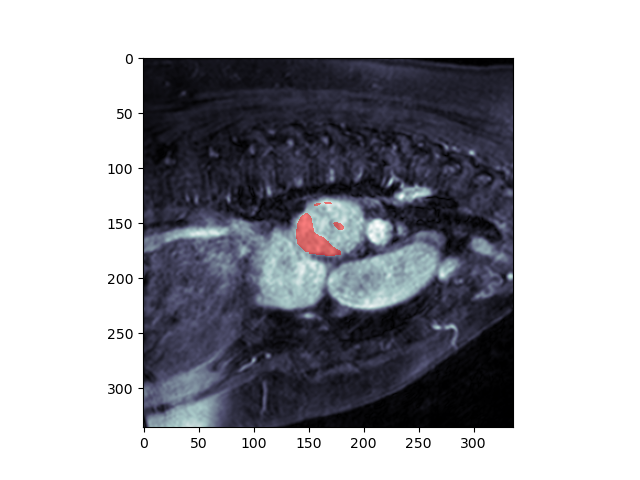

In [92]:
fig = plt.figure()
camera = Camera(fig)  

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")
    
    camera.snap()  
animation = camera.animate()  

In [93]:
from IPython.display import HTML
HTML(animation.to_html5_video())  



In [ ]:
werrty